# Bootstrapping Datasets

In previous examples we assumed that there was a pre-existing dataset available for us to use.
This is typically the case when working with literature datasets or if we perform the dataset acquisition with an external (molecular dyamics) program.

However, in active learning scenarios one typically starts with a single (unlabeled) configuration. In these cases it is often convenient to bootstrap an initial training set in order to quickly obtain a stable force field with which to drive the sampling.

A full active learning example can be found in a later notebook in this series.

This notebook requires packmol for setting up the initial configuration and the xtb. 
`xtb-python` and `packmol` are available from conda and can be installed via

```bash
conda install -c conda-forge xtb-python
conda install -c conda-forge packmol
```

In [1]:
import ipsuite as ips
import znflow
import matplotlib.pyplot as plt

from zntrack.utils import cwd_temp_dir

temp_dir = cwd_temp_dir()

2023-05-30 16:18:18,325 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [3]:
!git init
!dvc init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /tmp/tmp8k077isy/.git/
Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                          

We can use packmol to create an initial configuration.
Based on this, it is possible to bootstrap datasets using a combination of various methods.
Each of them is designed to probe a different seet of degrees of freedom.
Random atomic displacements will probe vibrations, while random translations and rotations of molecules, as well as box size scans probe slower degrees of freedom that depend on intermolecular interactions.

In [ ]:
mapping = ips.geometry.BarycenterMapping()

with ips.Project() as project:
    water = ips.SmilesToAtoms(smiles="O")
    packmol = ips.Packmol(
        data=[water.atoms], count=[10], density=997
    )

    opt_calc = ips.xTBSinglePoint(data=packmol, method="gfn1-xtb", name="opt_calc")

    geopt = ips.ASEGeoOpt(
        model=opt_calc,
        data=packmol.atoms,
        optimizer="BFGS",
        run_kwargs={"fmax": 1.0},
    )

    n_configs = 5
    rattle = ips.bootstrap.RattleAtoms(
        data=geopt.atoms,
        data_id=-1,
        n_configurations=n_configs,
        maximum=0.08, # Ang max atomic displacement
        include_original=True
    )
    rotate = ips.bootstrap.RotateMolecules(
        data=geopt.atoms,
        data_id=-1,
        n_configurations=n_configs,
        maximum=15,  # deg max rotation
        include_original=False
    )
    translate = ips.bootstrap.TranslateMolecules(
        data=geopt.atoms,
        data_id=-1,
        n_configurations=n_configs,
        maximum=0.3, # Ang max molecular displacement
        include_original=False
    )

    bootstrap_configurations = rattle.atoms + rotate.atoms + translate.atoms

    labeling_calc = ips.xTBSinglePoint(data=bootstrap_configurations, method="gfn1-xtb", name="label_calc")
    volume_scan = ips.BoxScale(
        data=rattle.atoms,
        data_id=0,
        model=labeling_calc,
        mapping=mapping,
        start=0.8,
        stop=1.5,
        num=5,
    )
    bootstrap_dataset = znflow.combine([labeling_calc, volume_scan], attribute="atoms")

    energy_hist = ips.EnergyHistogram(data=bootstrap_dataset, bins=10)
    forces_hist = ips.ForcesHistogram(data=bootstrap_dataset, bins=10)

project.repro()

Running DVC command: 'stage add --name SmilesToAtoms --force ...'
Running DVC command: 'stage add --name Packmol --force ...'
Running DVC command: 'stage add --name opt_calc --force ...'
Running DVC command: 'stage add --name ASEGeoOpt --force ...'
Running DVC command: 'stage add --name RattleAtoms --force ...'
Running DVC command: 'stage add --name RotateMolecules --force ...'
Running DVC command: 'stage add --name TranslateMolecules --force ...'
Running DVC command: 'stage add --name label_calc --force ...'
Running DVC command: 'stage add --name BoxScale --force ...'
Running DVC command: 'stage add --name BoxScale_mapping --force ...'
Could not create .gitignore entry in /tmp/tmp8k077isy/nodes/BoxScale_mapping/.gitignore. DVC will attempt to create .gitignore entry again when the stage is run.
Running DVC command: 'stage add --name EnergyHistogram --force ...'
Running DVC command: 'stage add --name ForcesHistogram --force ...'
Running DVC command: 'repro'


2023-05-30 16:18:20,899 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!
2023-05-30 16:18:22,115 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!
2023-05-30 16:18:22,296 (INFO): estimated box size: [6.6946734740471925, 6.6946734740471925, 6.6946734740471925]

################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Seed for random number generator:      1234567
  Output file: mixture.xyz
  Reading coordinate file: 0.xyz
  Number of independent structures:            1
  The structures are: 
  Structure         

100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


2023-05-30 16:18:24,687 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!
      Step     Time          Energy         fmax
BFGS:    0 16:18:24    -1452.227673      560.1183
BFGS:    1 16:18:25    -1525.179018       73.0175
BFGS:    2 16:18:25    -1541.432084       26.5437
BFGS:    3 16:18:25    -1548.847866       20.9261
BFGS:    4 16:18:25    -1553.041573       21.0507
BFGS:    5 16:18:25    -1557.985665       14.9412
BFGS:    6 16:18:25    -1560.632213        8.3526
BFGS:    7 16:18:25    -1562.409822        5.2405
BFGS:    8 16:18:25    -1563.889836        4.6672
BFGS:    9 16:18:26    -1565.320047       13.2885
BFGS:   10 16:18:26    -1566.448285        3.4639
BFGS:   11 16:18:26    -1567.953756        4.4025
BFGS:   12 16:18:26    -1568.948496        7.1006
BFGS:   13 16:18:26    -1569.550374        4.1206
BFGS:   14 16:18:26    -1570.227879        2.1917
BFGS:   15 16:18:26    -1570.532967        7.2313
BFGS:   16 16:18:26    -1570.847957        2.6559
BFGS:   17 16:18:2

100%|██████████| 16/16 [00:01<00:00,  8.80it/s]


2023-05-30 16:18:36,564 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


Could not load field atoms for node BoxScale_mapping.
100%|███████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


2023-05-30 16:18:38,818 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!
2023-05-30 16:18:40,299 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


Lets inspect the label distribution of our new dataset.
While they produce a plot in the respective `nodes` subdirectory, we will recreate them here to view them from within the notebook.

In order to do that, we first have to load the histogram nodes.
Then we can create simple histogram with matplotlib.


In [5]:
energy_hist.load()
forces_hist.load()

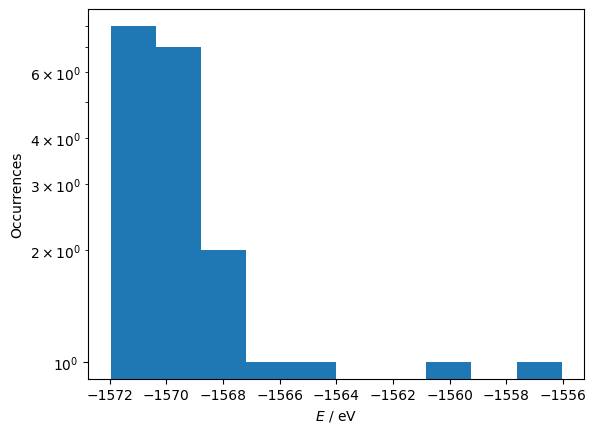

In [6]:
counts, bin_edges = energy_hist.get_hist()

plt.stairs(counts, bin_edges, fill=True)
plt.xlabel(energy_hist.xlabel)
plt.ylabel(energy_hist.ylabel)
plt.yscale("log")
plt.show()


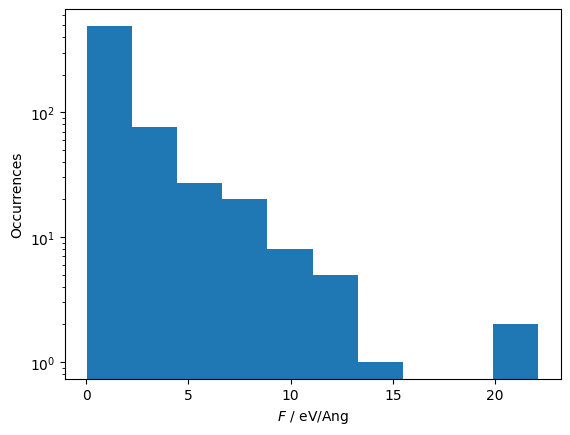

In [7]:
counts, bin_edges = forces_hist.get_hist()

plt.stairs(counts, bin_edges, fill=True)
plt.xlabel(forces_hist.xlabel)
plt.ylabel(forces_hist.ylabel)
plt.yscale("log")
plt.show()

In both histograms we can see some outliers with fairly high energies / large forces.
While a few configurations like this are usually not detrimental to model performance, one should tune the displacement parameters such as to not obtain completely unphysical configurations.

The data created here could now be supplied to a model Node and used for training.

In [9]:
temp_dir.cleanup()